In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import copy
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

In [2]:
rutaArchivoDatos = (r"./recursos/1000gruposCluster.csv")
#el modelo y todos los archivos de salida se guardaran en el directorio ./modelos/
nombreModeloSalida = "forestRegressor.joblib"

In [3]:
data = pd.read_csv(rutaArchivoDatos)

data_filtered = data.drop(['NumParadas', 'PorcentajePunto', 'Retraso', 'Cluster'], axis=1)
data_filtered

label_encoder_array = []
for col in data_filtered.columns:
    if data_filtered[col].dtype == 'object':
        label_encoder = LabelEncoder()
        data_filtered[col] = label_encoder.fit_transform(data[col])
        new_label_encoder = copy.deepcopy(label_encoder)
        label_encoder_array.append(new_label_encoder)

In [14]:
# # Cargar el dataset de iris
# data = load_iris()
# X = data.data
# print(X)
# y = data.target

# # Dividir los datos en entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X = data_filtered.drop('Puntuacion', axis=1)  # Ajusta 'target_column' al nombre de tu columna de destino
y = data_filtered['Puntuacion']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# print(X_train)

# Definir el modelo de Keras
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

# Clase para integrar Keras con scikit-learn para regresión
class KerasRegressorMSE(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, epochs=100, batch_size=32, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        self.model_ = self.build_fn()
        self.history_ = self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model_.predict(X).flatten()

    def score(self, X, y):
        y_pred = self.predict(X)
        return -np.mean((y_pred - y) ** 2)  # Usar MSE negativo para que mayor sea mejor

# Integrar el modelo de Keras con scikit-learn
keras_reg = KerasRegressorMSE(build_model, epochs=50, batch_size=32, verbose=1)

# Entrenar el modelo
keras_reg.fit(X_train, y_train)

# Evaluar el modelo
mse = -keras_reg.score(X_test, y_test)
print(f'Mean Squared Error: {mse}')

C:\Users\pablo.gallardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 1147.6741 - mean_absolute_error: 25.9340 - mean_squared_error: 1147.6741
Epoch 2/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 281.9465 - mean_absolute_error: 13.2377 - mean_squared_error: 281.9465
Epoch 3/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 265.3880 - mean_absolute_error: 12.7115 - mean_squared_error: 265.3880
Epoch 4/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 258.2160 - mean_absolute_error: 12.5685 - mean_squared_error: 258.2160
Epoch 5/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 254.3327 - mean_absolute_error: 12.4341 - mean_squared_error: 254.3327
Epoch 6/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 249.1364 - mean_absolute_error: 12.3105 - mean_squared_error: 249.1364
Epoch 7/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 244.5641 - mean_absolute_error: 12.1826 - mean_squared_error: 244.5641
Epoch 8/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 240.6

    TARDA 20 MINUTOS

In [35]:
# Clase para integrar Keras con scikit-learn para regresión
class KerasRegressorR2(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, epochs=100, batch_size=32, verbose=0):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose

    def fit(self, X, y):
        self.model_ = self.build_fn()
        self.history_ = self.model_.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model_.predict(X).flatten()

    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)

    def get_history(self):
        return self.history_

# Integrar el modelo de Keras con scikit-learn
keras_reg = KerasRegressorR2(build_model, epochs=50, batch_size=16, verbose=1)

# Entrenar el modelo
keras_reg.fit(X_train, y_train)

# Evaluar el modelo usando R2
r2 = keras_reg.score(X_test, y_test)
print(f'R2 Score: {r2:.2f}')

C:\Users\pablo.gallardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7675/7675 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 1638.3092 - mean_absolute_error: 24.6171 - mean_squared_error: 1638.3092
Epoch 2/50
7675/7675 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 277.5023 - mean_absolute_error: 13.0712 - mean_squared_error: 277.5023
Epoch 3/50
7675/7675 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 267.6709 - mean_absolute_error: 12.8185 - mean_squared_error: 267.6709
Epoch 4/50
7675/7675 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 257.2392 - mean_absolute_error: 12.5803 - mean_squared_error: 257.2392
Epoch 5/50
7675/7675 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 251.4577 - mean_absolute_error: 12.4381 - mean_squared_error: 251.4577
Epoch 6/50
7675/7675 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 248.9280 - mean_absolute_error: 12.3665 - mean_squared_error: 248.9280
Epoch 7/50
7675/7675 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - loss: 241.4977 - mean_absolute_error: 12.1482 - mean_squared_error: 241.4977
Epoch 8/50
7675/7675 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - los

    TARDA MEDIA HORA

In [21]:

# Validación cruzada con K-Fold
kfold = KFold(n_splits=5, shuffle=True, random_state=42) 

# Calcular las puntuaciones de validación cruzada
scores = cross_val_score(keras_reg, X, y, cv=kfold, scoring='r2', n_jobs=5)

C:\Users\pablo.gallardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 951.8849 - mean_absolute_error: 24.7921 - mean_squared_error: 951.8849
Epoch 2/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 273.0572 - mean_absolute_error: 13.0684 - mean_squared_error: 273.0571
Epoch 3/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 257.8784 - mean_absolute_error: 12.6408 - mean_squared_error: 257.8783
Epoch 4/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 250.6585 - mean_absolute_error: 12.4358 - mean_squared_error: 250.6585
Epoch 5/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 241.7235 - mean_absolute_error: 12.2121 - mean_squared_error: 241.7235
Epoch 6/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 238.9911 - mean_absolute_error: 12.1037 - mean_squared_error: 238.9911
Epoch 7/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 232.7661 - mean_absolute_error: 11.9564 - mean_squared_error: 232.7661
Epoch 8/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 229.5

C:\Users\pablo.gallardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3838/3838 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 32652.8164 - mean_absolute_error: 81.9862 - mean_squared_error: 32652.8164
Epoch 2/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 333.4584 - mean_absolute_error: 14.5371 - mean_squared_error: 333.4584
Epoch 3/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 270.3190 - mean_absolute_error: 12.9351 - mean_squared_error: 270.3190
Epoch 4/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 255.7217 - mean_absolute_error: 12.5585 - mean_squared_error: 255.7217
Epoch 5/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 246.6692 - mean_absolute_error: 12.3158 - mean_squared_error: 246.6692
Epoch 6/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 242.4206 - mean_absolute_error: 12.1953 - mean_squared_error: 242.4206
Epoch 7/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 238.0243 - mean_absolute_error: 12.0685 - mean_squared_error: 238.0243
Epoch 8/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 239.4176 - mea

C:\Users\pablo.gallardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 8438.0508 - mean_absolute_error: 41.7902 - mean_squared_error: 8438.0508
Epoch 2/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 335.9012 - mean_absolute_error: 14.5153 - mean_squared_error: 335.9012
Epoch 3/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 290.0046 - mean_absolute_error: 13.4381 - mean_squared_error: 290.0046
Epoch 4/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 276.7092 - mean_absolute_error: 13.1001 - mean_squared_error: 276.7092
Epoch 5/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 271.0688 - mean_absolute_error: 12.9530 - mean_squared_error: 271.0688
Epoch 6/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 264.4473 - mean_absolute_error: 12.8201 - mean_squared_error: 264.4473
Epoch 7/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 257.9402 - mean_absolute_error: 12.6326 - mean_squared_error: 257.9402
Epoch 8/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - los

C:\Users\pablo.gallardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3838/3838 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1405.0220 - mean_absolute_error: 24.7133 - mean_squared_error: 1405.0220
Epoch 2/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 280.4578 - mean_absolute_error: 13.1748 - mean_squared_error: 280.4578
Epoch 3/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 270.0911 - mean_absolute_error: 12.9236 - mean_squared_error: 270.0911
Epoch 4/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 262.3840 - mean_absolute_error: 12.7164 - mean_squared_error: 262.3840
Epoch 5/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 259.3161 - mean_absolute_error: 12.6565 - mean_squared_error: 259.3161
Epoch 6/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 255.7534 - mean_absolute_error: 12.5501 - mean_squared_error: 255.7534
Epoch 7/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 249.9152 - mean_absolute_error: 12.3844 - mean_squared_error: 249.9152
Epoch 8/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 249.8379 - mean_

C:\Users\pablo.gallardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3838/3838 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3415.0447 - mean_absolute_error: 30.7710 - mean_squared_error: 3415.0447
Epoch 2/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 290.4368 - mean_absolute_error: 13.4020 - mean_squared_error: 290.4368
Epoch 3/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 275.7650 - mean_absolute_error: 13.0172 - mean_squared_error: 275.7650
Epoch 4/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 262.5649 - mean_absolute_error: 12.6843 - mean_squared_error: 262.5650
Epoch 5/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 252.0793 - mean_absolute_error: 12.4239 - mean_squared_error: 252.0793
Epoch 6/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 251.0024 - mean_absolute_error: 12.3976 - mean_squared_error: 251.0024
Epoch 7/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 246.5618 - mean_absolute_error: 12.3137 - mean_squared_error: 246.5618
Epoch 8/50
3838/3838 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 244.0849 - mean

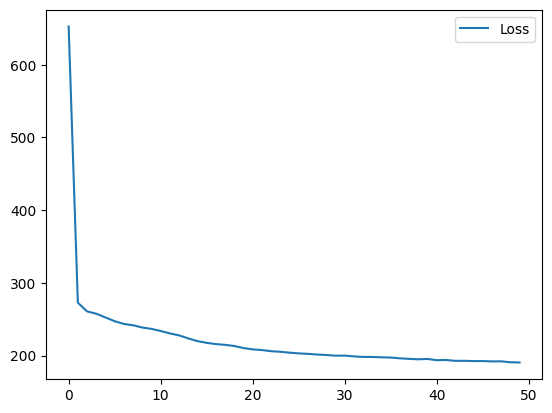

In [22]:
history = keras_reg.history_
loss_values =  history.history['loss']
# val_loss_values = history.history.get('val_loss', [])
# print(val_loss_values)
plt.plot(range(0, 50, 1), loss_values, label='Loss')
plt.legend()
plt.show()

In [27]:
conductores = data['IDConductor'].unique()
paradasCarga = pd.read_csv(r"./modelos/paradasCarga.csv")
paradasDescarga = pd.read_csv(r"./modelos/paradasDescarga.csv")
conductores.shape
import random

paradaCargaIndex = random.randint(0, len(paradasCarga)-1)
print(paradasCarga.iloc[paradaCargaIndex].CodigoInternoPuntoCarga, paradasCarga.iloc[paradaCargaIndex].LatitudPuntoCarga, paradasCarga.iloc[paradaCargaIndex].LongitudPuntoCarga)
paradaDescargaIndex = random.randint(0, len(paradasDescarga)-1)
lista_conductores_puntuacion = []
for conductor in conductores:
    km_vacio = random.randint(40, 400)
    to_pred = pd.DataFrame([{
        'IDConductor': conductor, 
        'CodigoInternoPuntoCarga': paradasCarga.iloc[paradaCargaIndex].CodigoInternoPuntoCarga,  
        'LatitudPuntoCarga': paradasCarga.iloc[paradaCargaIndex].LatitudPuntoCarga,
        'LongitudPuntoCarga': paradasCarga.iloc[paradaCargaIndex].LongitudPuntoCarga,
        'CodigoInternoPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].CodigoInternoPuntoDescarga,
        'LatitudPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].LatitudPuntoDescarga,
        'LongitudPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].LongitudPuntoDescarga,
        'KmVacio': km_vacio
    }])

    i= 0
    for col in to_pred.columns:
        # print(col)
        if to_pred[col].dtype == 'object':
            to_pred[col] = label_encoder_array[i].transform(to_pred[col])
            i+=1
    # print(to_pred)
    # print(to_pred['IDconductor'], "\n", to_pred['CodigoInternoParadaCarga'], "\n", to_pred['CodigoInternoParadaDescarga'])

    prediction = keras_reg.predict(to_pred)
    # print("Conductor ", conductor, ": ", prediction)
    puntuacion_conductor = {"Conductor": conductor, "KmVacio": km_vacio, "Prediccion": prediction}
    lista_conductores_puntuacion.append(puntuacion_conductor)


print(lista_conductores_puntuacion)

conductores_ordenados = sorted(lista_conductores_puntuacion, key=lambda x: x["Prediccion"], reverse=True)
conductores_menosKM = sorted(lista_conductores_puntuacion, key=lambda x: x['KmVacio'], reverse=False)

for conductor in conductores_menosKM[:5]:
    print(conductor)

print("Mejores conductores:")
for conductor in conductores_ordenados[:5]:
    print(conductor)
    

24840169-RUTA2-20 45.6368 8.8342
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


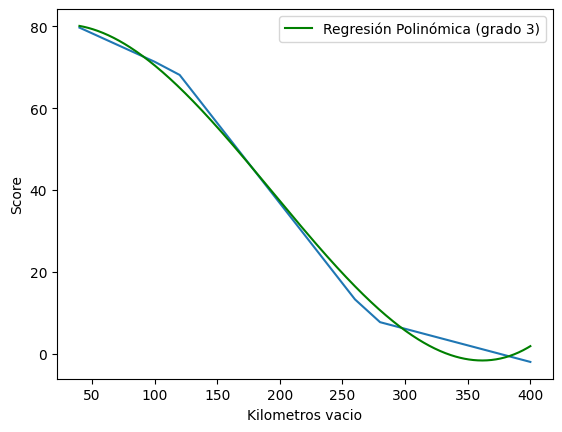

In [28]:
lista_conductorX_puntuaciones = []
conductor = "Y4446672G"
for km_vacio in range(40, 401, 20):
    to_pred = pd.DataFrame([{
        'IDConductor': conductor, 
        'CodigoInternoPuntoCarga': paradasCarga.iloc[paradaCargaIndex].CodigoInternoPuntoCarga,  
        'LatitudPuntoCarga': paradasCarga.iloc[paradaCargaIndex].LatitudPuntoCarga,
        'LongitudPuntoCarga': paradasCarga.iloc[paradaCargaIndex].LongitudPuntoCarga,
        'CodigoInternoPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].CodigoInternoPuntoDescarga,
        'LatitudPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].LatitudPuntoDescarga,
        'LongitudPuntoDescarga': paradasDescarga.iloc[paradaDescargaIndex].LongitudPuntoDescarga,
        'KmVacio': km_vacio
    }])

    i= 0
    for col in to_pred.columns:
        # print(col)
        if to_pred[col].dtype == 'object':
            to_pred[col] = label_encoder_array[i].transform(to_pred[col])
            i+=1

    
    prediction = keras_reg.predict(to_pred)
    # print("Conductor ", conductor, ": ", prediction)
    puntuacion_conductor = {"Conductor": conductor, "KmVacio": km_vacio, "Prediccion": prediction[0]}
    lista_conductorX_puntuaciones.append(puntuacion_conductor)
    

# for item in lista_conductorX_puntuaciones:
#     print(item)


# Extraer los valores de KmVacio y Prediccion
km_vacio = np.array([x["KmVacio"] for x in lista_conductorX_puntuaciones])
predicciones = np.array([x["Prediccion"] for x in lista_conductorX_puntuaciones])

# Ajustar una regresión polinómica (grado 2 en este caso)
grado = 3
coef = np.polyfit(km_vacio, predicciones, grado)
polinomio = np.poly1d(coef)

# Calcular los valores predichos usando el polinomio
y_pred2 = polinomio(km_vacio)

plt.plot(range(40, 401, 20), [x["Prediccion"] for x in lista_conductorX_puntuaciones])
# Graficar la curva de regresión polinómica
x_range = np.linspace(km_vacio.min(), km_vacio.max(), 500)
plt.plot(x_range, polinomio(x_range), color='green', label=f'Regresión Polinómica (grado {grado})')
plt.xlabel('Kilometros vacio')
plt.ylabel('Score')
plt.legend()
plt.show()